In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')


### Load and preprocess the dataset

In [2]:
def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)
    data = data.drop(columns=[col for col in data.columns if "Unnamed" in col], errors='ignore')
    data['country'] = data['country'].astype(str)  # Convert 'country' to categorical strings
    X = data.drop(columns=['result'])
    y = data['result']
    categorical_cols = ['country', 'location', 'gender', 'vis_wuhan', 'from_wuhan']
    numerical_cols = [col for col in X.columns if col not in categorical_cols]
    return X, y, categorical_cols, numerical_cols

### Split dataset into training, validation, and test sets

In [3]:
def split_data(X, y):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    return X_train, X_val, X_test, y_train, y_val, y_test

### Create preprocessing pipeline

In [4]:
def create_preprocessor(categorical_cols, numerical_cols):
    categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    numerical_transformer = StandardScaler()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )
    return preprocessor

### Plot a confusion matrix

In [5]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

### Evaluate model performance

In [6]:
def evaluate_model(model, X_val, X_test, y_val, y_test, name):
    """Evaluate the given model using validation and test sets."""
    # Validation set evaluation
    y_val_pred = model.predict(X_val)
    y_val_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else None
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_roc_auc = roc_auc_score(y_val, y_val_prob) if y_val_prob is not None else "N/A"
    
    print(f"\n{name} Validation Accuracy: {val_accuracy:.2f}")
    if y_val_prob is not None:
        print(f"{name} Validation ROC-AUC: {val_roc_auc:.2f}")
    
    # Test set evaluation
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    report = classification_report(y_test, y_pred, target_names=['Recovered', 'Death'], output_dict=True)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{name} Test Classification Report:\n{classification_report(y_test, y_pred, target_names=['Recovered', 'Death'])}")
    print(f"{name} Test Accuracy: {accuracy:.2f}")
    if y_prob is not None:
        print(f"{name} Test ROC-AUC: {roc_auc:.2f}")
    plot_confusion_matrix(cm, classes=['Recovered', 'Death'], title=f'{name} Test Confusion Matrix')

    return y_prob, roc_auc

### Train and evaluate a specific classifier

In [7]:
def train_and_evaluate_classifier(model, param_grid, model_name, preprocessor, X_train, y_train, X_val, X_test, y_val, y_test, results, roc_curves):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_prob, roc_auc = evaluate_model(best_model, X_val, X_test, y_val, y_test, model_name)
    results.append({
        'model': model_name,
        'accuracy': accuracy_score(y_test, best_model.predict(X_test)),
        'roc_auc': roc_auc
    })
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_curves.append((model_name, fpr, tpr, roc_auc))

### Main function for executing the project


--- K-Nearest Neighbors ---

KNN Validation Accuracy: 0.95
KNN Validation ROC-AUC: 0.96

KNN Test Classification Report:
              precision    recall  f1-score   support

   Recovered       0.95      0.97      0.96       152
       Death       0.76      0.62      0.68        21

    accuracy                           0.93       173
   macro avg       0.86      0.80      0.82       173
weighted avg       0.93      0.93      0.93       173

KNN Test Accuracy: 0.93
KNN Test ROC-AUC: 0.94


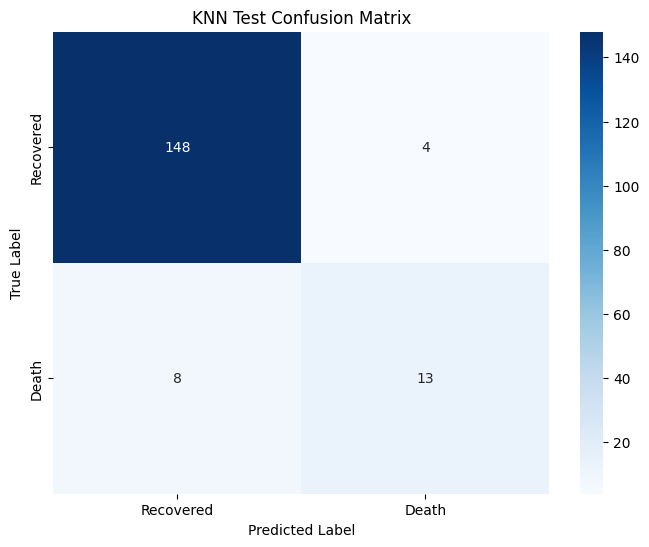


--- Logistic Regression ---

Logistic Regression Validation Accuracy: 0.95
Logistic Regression Validation ROC-AUC: 0.99

Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

   Recovered       0.97      0.99      0.98       152
       Death       0.94      0.81      0.87        21

    accuracy                           0.97       173
   macro avg       0.96      0.90      0.93       173
weighted avg       0.97      0.97      0.97       173

Logistic Regression Test Accuracy: 0.97
Logistic Regression Test ROC-AUC: 0.99


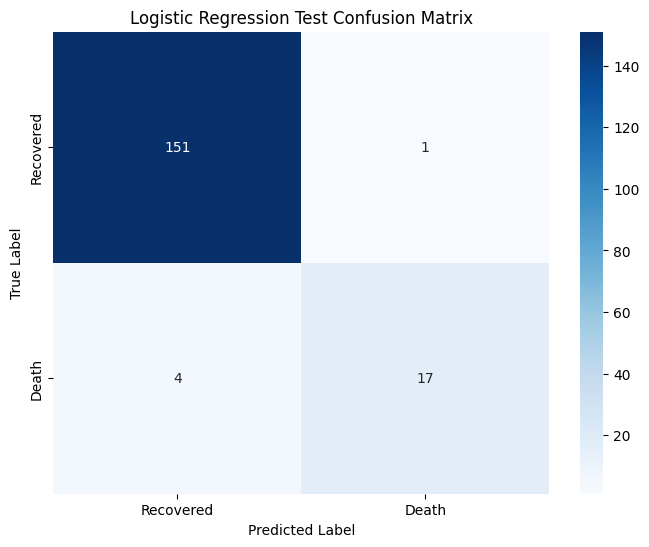


--- Naive Bayes ---

Naive Bayes Validation Accuracy: 0.54
Naive Bayes Validation ROC-AUC: 0.74

Naive Bayes Test Classification Report:
              precision    recall  f1-score   support

   Recovered       0.99      0.47      0.64       152
       Death       0.20      0.95      0.33        21

    accuracy                           0.53       173
   macro avg       0.59      0.71      0.49       173
weighted avg       0.89      0.53      0.60       173

Naive Bayes Test Accuracy: 0.53
Naive Bayes Test ROC-AUC: 0.71


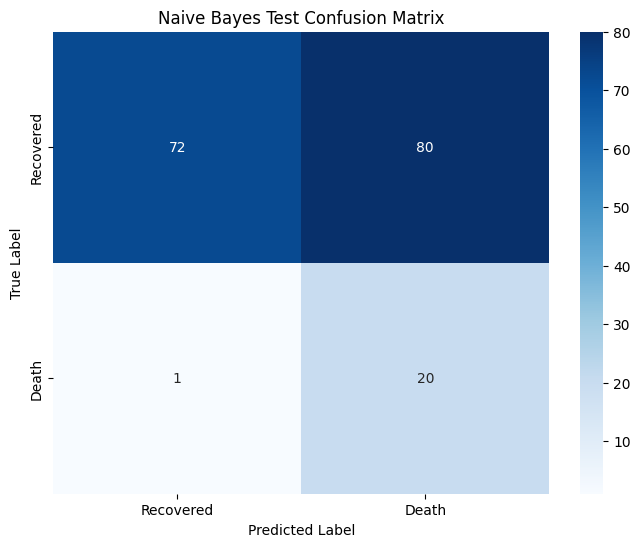


--- Decision Tree ---

Decision Tree Validation Accuracy: 0.94
Decision Tree Validation ROC-AUC: 0.85

Decision Tree Test Classification Report:
              precision    recall  f1-score   support

   Recovered       1.00      0.97      0.98       152
       Death       0.81      1.00      0.89        21

    accuracy                           0.97       173
   macro avg       0.90      0.98      0.94       173
weighted avg       0.98      0.97      0.97       173

Decision Tree Test Accuracy: 0.97
Decision Tree Test ROC-AUC: 0.99


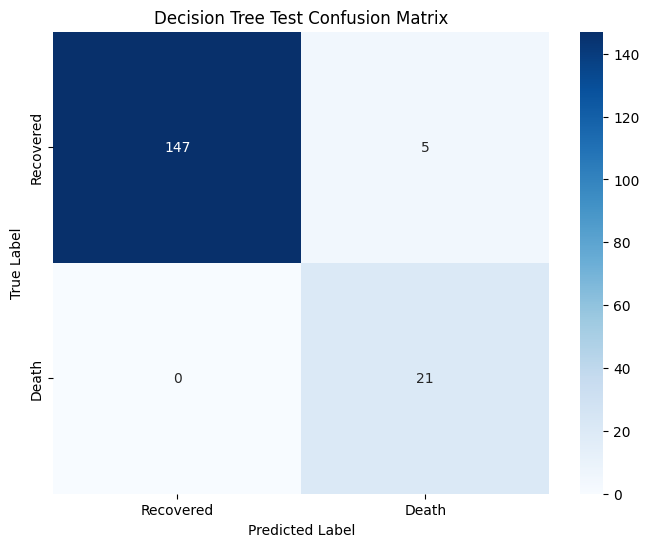


--- Support Vector Machine ---

SVM Validation Accuracy: 0.94
SVM Validation ROC-AUC: 0.98

SVM Test Classification Report:
              precision    recall  f1-score   support

   Recovered       0.97      0.97      0.97       152
       Death       0.77      0.81      0.79        21

    accuracy                           0.95       173
   macro avg       0.87      0.89      0.88       173
weighted avg       0.95      0.95      0.95       173

SVM Test Accuracy: 0.95
SVM Test ROC-AUC: 0.94


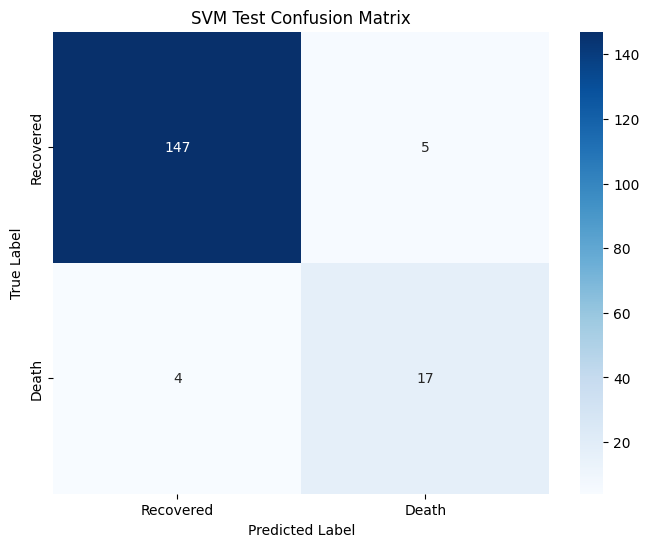


Final Model Comparison:
                 model  accuracy   roc_auc
3        Decision Tree  0.971098  0.994518
1  Logistic Regression  0.971098  0.991855
4                  SVM  0.947977  0.942356
0                  KNN  0.930636  0.940476
2          Naive Bayes  0.531792  0.713033


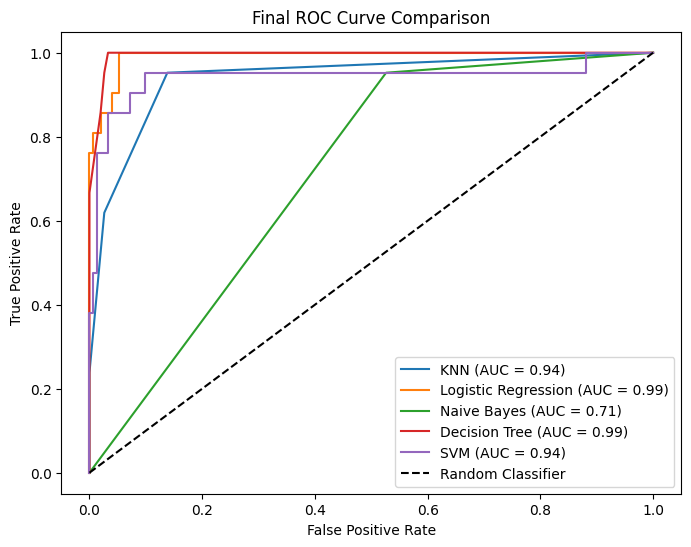

In [8]:
def main(filepath):
    X, y, categorical_cols, numerical_cols = load_and_preprocess_data(filepath)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
    preprocessor = create_preprocessor(categorical_cols, numerical_cols)

    results = []
    roc_curves = []

    # K-Nearest Neighbors
    print("\n--- K-Nearest Neighbors ---")
    knn_params = {'classifier__n_neighbors': range(1, 21)}
    train_and_evaluate_classifier(KNeighborsClassifier(), knn_params, "KNN", preprocessor, X_train, y_train, X_val, X_test, y_val, y_test, results, roc_curves)

    # Logistic Regression
    print("\n--- Logistic Regression ---")
    logistic_params = {'classifier__C': [0.01, 0.1, 1, 10, 100], 'classifier__max_iter': [100, 200, 500]}
    train_and_evaluate_classifier(LogisticRegression(random_state=42), logistic_params, "Logistic Regression", preprocessor, X_train, y_train, X_val, X_test, y_val, y_test, results, roc_curves)

    # Naive Bayes
    print("\n--- Naive Bayes ---")
    nb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', GaussianNB())])
    nb_pipeline.fit(X_train, y_train)
    y_prob, roc_auc = evaluate_model(nb_pipeline, X_val, X_test, y_val, y_test, "Naive Bayes")
    results.append({
        'model': "Naive Bayes",
        'accuracy': accuracy_score(y_test, nb_pipeline.predict(X_test)),
        'roc_auc': roc_auc
    })
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_curves.append(("Naive Bayes", fpr, tpr, roc_auc))

    # Decision Tree
    print("\n--- Decision Tree ---")
    dt_params = {'classifier__max_depth': [3, 5, 10, None], 'classifier__min_samples_split': [2, 5, 10]}
    train_and_evaluate_classifier(DecisionTreeClassifier(random_state=42), dt_params, "Decision Tree", preprocessor, X_train, y_train, X_val, X_test, y_val, y_test, results, roc_curves)

    # Support Vector Machine
    print("\n--- Support Vector Machine ---")
    svm_params = {'classifier__C': [0.1, 1, 10], 'classifier__gamma': [0.01, 0.1, 1], 'classifier__kernel': ['rbf']}
    train_and_evaluate_classifier(SVC(probability=True, random_state=42), svm_params, "SVM", preprocessor, X_train, y_train, X_val, X_test, y_val, y_test, results, roc_curves)

    # Final Comparison
    comparison_df = pd.DataFrame(results)
    comparison_df.sort_values(by='roc_auc', ascending=False, inplace=True)
    print("\nFinal Model Comparison:")
    print(comparison_df)

    # Plot final ROC curves
    plt.figure(figsize=(8, 6))
    for model_name, fpr, tpr, roc_auc in roc_curves:
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Final ROC Curve Comparison')
    plt.legend()
    plt.show()

# Run the main function
if __name__ == "__main__":
    main("data.csv")